# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1Qer0iNZqL3snyLnH2W2PyJZCFSHHaHk7#scrollTo=RS76ATsjdi5x

Share Link: https://drive.google.com/file/d/1Qer0iNZqL3snyLnH2W2PyJZCFSHHaHk7/view?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install torchtext==0.6

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [ ]:
import torchtext

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Unzipping the file in drive
!unzip '/content/drive/MyDrive/Colab Notebooks/APS360/Lab5 Data/sms+spam+collection.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/APS360/Lab5 Data/sms+spam+collection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#Open the SMSSpamCollection file into colab
with open('SMSSpamCollection') as f:
    file_content = f.read()

In [ ]:
#Splitting the data into a list of strings separated by the newline character
messages=file_content.split('\n')

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
spam_example_printed = False  #Flag to determine if a spam example has been printed
ham_example_printed = False  #Flag to determine if a non-spam example has been printed

for message in messages:
    label, text = message.split('\t', 1)  # Split label and text
    if label == 'spam' and not spam_example_printed: #Check if spam
        print("The Spam label is:", label)
        print("Spam example:", text)
        spam_example_printed = True
    elif label == 'ham' and not ham_example_printed: #Check if not spam
        print("The Non-Spam label is:", label)
        print("Non-Spam example:", text)
        ham_example_printed = True
    if spam_example_printed and ham_example_printed: #End if both are printed
        break




The Non-Spam label is: ham
Non-Spam example: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
The Spam label is: spam
Spam example: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
#Remove any accidentally created lines in the data without delimiter
for message in messages:
  if '\t' not in message:
    messages.remove(message)


In [ ]:
spamct=0 #Counter for number of spam examples
hamct=0 #Counter for number of non-spam examples
for message in messages:
        label, text = message.split('\t', 1)  # Split label and text
        if label == 'spam':
            spamct+=1
        elif label == 'ham':
            hamct+=1

print(f"There are {spamct} spam messages.")
print(f"There are {hamct} non-spam messages.")

There are 747 spam messages.
There are 4827 non-spam messages.


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

###Advantages:

1. There are a lot less total characters than words, so the model only needs to learn embeddings for about 100 characters rather than for hundreds to thousands of words.
2. The model won't require a vocabulary of words and as a result it isn't limited to a pre-set list of words and can process any word.

###Disadvantages:

1. The model may not be able to identify mispelled words and non-existent words since it doesn't look at the entire word, only its components.
2. The sequence passed to the model will be much longer due to the fact that a sentence will always contain more characters than words.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
# Define two fields: one for the text and one for the labels
text_field = torchtext.data.Field(
    sequential=True,  # Indicates that the data is sequential (like text)
    tokenize=lambda x: x,  # Tokenizes the text by individual characters
    include_lengths=True,  # Includes the length of each sequence in the batch
    batch_first=True,  # Returns batches with the batch dimension first
    use_vocab=True  # Builds a vocabulary of characters
)

label_field = torchtext.data.Field(
    sequential=False,  # Indicates that the labels are not sequential
    use_vocab=False,  # Doesn't build a vocabulary for labels (they are already numerical)
    preprocessing=lambda x: int(x=='spam'),  # Converts labels to binary (1 for spam, 0 for not spam)
    is_target=True,  # Specifies that this field contains the target labels
    batch_first=True  # Returns batches with the batch dimension first
)

#Create a dataset from the sms file
dataset = torchtext.data.TabularDataset(
    path='SMSSpamCollection', #Path to data file
    format='tsv', #Format of data file
    fields=[('label', label_field), ('sms', text_field)] #Defines data fields
)

#Splits data into training, validation, and testing
train, valid, test = dataset.split(split_ratio=[0.6, 0.2, 0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

A balanced dataset is crucial to achieving an unbiased model. If there is many more non-spam examples than spam examples, then the model may simply guess non-spam everytime and still achieve a high accuracy. We want the model to be able to classify the spam and non-spam examples with similar accuracy and an unbalanced dataset may lead to unbalanced accuracies.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

#Count and print the spam and non-spam examples to check for balance
spamct=0
hamct=0
for message in train.examples:
        label = message.label
        text = message.sms
        if label == 1:
            spamct+=1
        elif label == 0:
            hamct+=1

print(f"There are {spamct} spam messages.")
print(f"There are {hamct} non-spam messages.")

There are 3241 spam messages.
There are 2880 non-spam messages.


### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

`text_field.vocab.stoi` is a dictionary assigning a number index to each possible character found in our dataset.

`text_field.vocab.itos` is a list containing each possible character in the dataset.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

`<unk>` represents an unknown character, this can help with character that may
appear in testing or validation, but not in training.

`<pad>` is a padding character that is added to the end of sequences to make sure
that all sequences in the same batch have the same length.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
#Using a data loader to load the data for our model (seperates with minimal padding)
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
x=0 #Counter to make sure we only print 10 batches
for batch in train_iter:
    x+=1
    num_pads=0
    #Check if character is a padding character for each character in batch.
    for sms in batch.sms[0]:
      for i in sms:
        if i==1:
          num_pads+=1
    print("Batch", x)
    print("Maximum Sequence Length:", len(batch.sms[0][1]), ", Number of <pad> tokens:", num_pads, "\n")
    if x == 10:
      break

Batch 1
Maximum Sequence Length: 51 , Number of <pad> tokens: 24 

Batch 2
Maximum Sequence Length: 142 , Number of <pad> tokens: 20 

Batch 3
Maximum Sequence Length: 162 , Number of <pad> tokens: 11 

Batch 4
Maximum Sequence Length: 45 , Number of <pad> tokens: 36 

Batch 5
Maximum Sequence Length: 135 , Number of <pad> tokens: 34 

Batch 6
Maximum Sequence Length: 70 , Number of <pad> tokens: 29 

Batch 7
Maximum Sequence Length: 40 , Number of <pad> tokens: 33 

Batch 8
Maximum Sequence Length: 143 , Number of <pad> tokens: 20 

Batch 9
Maximum Sequence Length: 156 , Number of <pad> tokens: 0 

Batch 10
Maximum Sequence Length: 158 , Number of <pad> tokens: 0 



## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class SMSRNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim):
        super().__init__()
        self.emb = torch.eye(vocab_size)#One-hot vector to embed data
        self.hidden_dim = hidden_dim#defines a hidden dim we can use in forward
        self.rnn = nn.RNN(vocab_size, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, 2)

    def forward(self, x):
        x = self.emb[x] #use one-hot encoding on the input batch
        hidden=torch.zeros(1, x.size(0), self.hidden_dim) #create a hidden state based on input
        output, _ = self.rnn(x,hidden) #put input through model
        output = torch.cat(
            [torch.max(output, dim=1)[0], torch.mean(output, dim=1)], dim=1) #Pool our output before passing it through fcn
        return self.fc(output)

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

    correct = 0 #Counts correctly predicted data
    total = 0 #Counts total data
    for batch in data:
        output = model(batch.sms[0]) #Makes prediction
        output=F.softmax(output, dim=1)
        pred=torch.argmax(output, dim=1)
        correct += (pred == batch.label).sum().item() #adds to correct if preditcion is correct
        total += len(batch.label)
    return correct / total

In [ ]:
def get_val_loss(model, data):
    """ Compute the validation loss of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_val_loss(model, valid) # the variable `valid` is from above
    """

    criterion = nn.CrossEntropyLoss()
    val_loss = 0 #Counts loss
    count=0 #Counts iterations
    for batch in data:
        output = model(batch.sms[0]) #make prediction
        loss = criterion(output, batch.label) #compute loss
        val_loss += loss.item()
        count+=1
    return val_loss/count

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [ ]:
def train_model(model, train_iter, valid_iter, num_epochs=30, lr=1e-4):

  #Define loss function and optimizer
  criterion=nn.CrossEntropyLoss()
  optimizer=optim.Adam(model.parameters(), lr=lr)

  #Create lists to record accuracy and loss
  train_loss=[]
  valid_loss=[]
  train_acc=[]
  valid_acc=[]

  for epoch in range(num_epochs):
    train_epoch_loss=0
    valid_epoch_loss=0
    train_epoch_acc=0
    valid_epoch_acc=0
    count=0
    for batch in train_iter:
      optimizer.zero_grad()
      output=model(batch.sms[0])
      loss=criterion(output, batch.label)
      train_epoch_loss+=loss.item()
      loss.backward()
      optimizer.step()
      count+=1
    #Computes epoch loss and acc and adds to list
    train_epoch_loss/=(count+1)
    train_epoch_acc=get_accuracy(model, train_iter)
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_epoch_acc=get_accuracy(model, valid_iter)
    valid_acc.append(valid_epoch_acc)
    valid_epoch_loss=get_val_loss(model, valid_iter)
    valid_loss.append(valid_epoch_loss)

    print(f"Epoch {epoch+1} Train Loss: {train_epoch_loss}, Train Accuracy: {train_epoch_acc}, Valid Loss: {valid_epoch_loss}, Valid Accuracy: {valid_epoch_acc}")

  return train_loss, valid_loss, train_acc, valid_acc


Epoch 1 Train Loss: 0.6552212769837723, Train Accuracy: 0.9496814246038229, Valid Loss: 0.6058361828327179, Valid Accuracy: 0.9524663677130045
Epoch 2 Train Loss: 0.33811499163047554, Train Accuracy: 0.9335075967979088, Valid Loss: 0.138549087362157, Valid Accuracy: 0.9829596412556054
Epoch 3 Train Loss: 0.16618357128319666, Train Accuracy: 0.9537657245548113, Valid Loss: 0.08998399952219592, Valid Accuracy: 0.9811659192825112
Epoch 4 Train Loss: 0.13718001538714797, Train Accuracy: 0.9539290965528509, Valid Loss: 0.08009519407318698, Valid Accuracy: 0.9811659192825112
Epoch 5 Train Loss: 0.12398726324137953, Train Accuracy: 0.9601372324783533, Valid Loss: 0.07086654628316562, Valid Accuracy: 0.9811659192825112
Epoch 6 Train Loss: 0.12570047586887462, Train Accuracy: 0.9586668844959974, Valid Loss: 0.08196157486074501, Valid Accuracy: 0.9775784753363229
Epoch 7 Train Loss: 0.11723213680280545, Train Accuracy: 0.9689593203724881, Valid Loss: 0.09681069499088658, Valid Accuracy: 0.973094

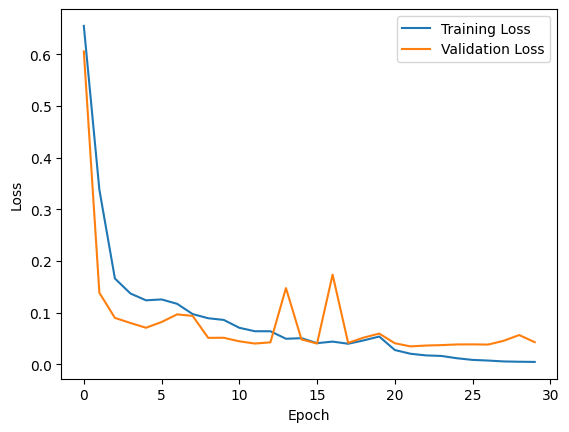

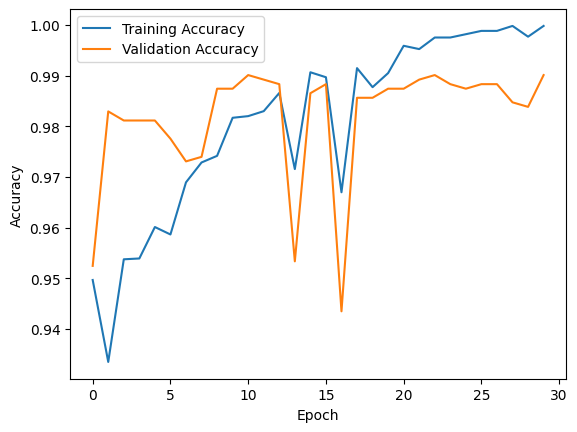

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

valid_iter = torchtext.data.BucketIterator(valid,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

model=SMSRNN(len(text_field.vocab.itos), 50)
train_loss, valid_loss, train_acc, valid_acc=train_model(model, train_iter, valid_iter, lr=.001)

import matplotlib.pyplot as plt

#Plots loss and validation curves
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

The four hyperparameters I will be tuning are the pooling method for the RNN outputs, learning rate, batch size, and hidden size. All networks will be trained to 30 epochs. The final model will be chosen as the model with the highest validation accuracy.


####Network 1: Max-pooling, LR = 1e-4, Batch Size = 32, Hidden Size = 50
The network achieved a training accuracy of .9591, a validation accuracy of .9587, a training loss of .1362, and a validation loss of .1399.

The network achieved a high accuracy early, but this accuracy did not grow very much during training and flatlined very early. As a result, I will try a new method of rnn output pooling as well as a larger hidden size.

####Network 2: Max-Mean Concatted Pooling, LR = 1e-4, Batch Size = 32, Hidden Size = Vocab Size
The network achieved a training accuracy of .9217, a validation accuracy of .9004, a training loss of .2583, and a validation loss of .2777.

The accuracy decreased drastically from network 1, which I think is a result of the increased hidden size. As a result, I will return to the original hidden size. To combat the slow growth I saw in network 1, I will increase the learning rate as well as the batch_size.

####Network 3: Max-Mean Concatted Pooling, LR = .001, Batch Size = 64, Hidden Size = 50
The network achieved a training accuracy of .9851, a validation accuracy of .9892, a training loss of .0540, and a validation loss of .0550.

This network performed much better than any of my previous models, and as a result I will settle with my current pooling and hidden size. However, I did notice that the validation accuracy did not peak yet, so I will try to increase the learning rate to see if I can train it faster.

####Network 4: Max-Mean Concatted Pooling, LR = .01, Batch Size = 64, Hidden Size = 50
The network achieved a training accuracy of .9924, a validation accuracy of .9785, a training loss of .0257, and a validation loss of .0735.

This model performed worse than network 3, which I believe is caused by overfitting. The learning rate was too high causing the model to memorize training data, and lose accuracy on the validation data.

Network 3 performed the best on the validation data and as a result will be the model I will use going forward.

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

valid_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
valid_nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [ ]:
print("Positive refers to identifying a message as spam.")
print("The model's validation false negative rate is", (1-get_accuracy(model, valid_nospam_iter))*100, "%")
print("The model's validation false positive rate is", (1-get_accuracy(model, valid_spam_iter))*100, "%")


Positive refers to identifying a message as spam.
The model's validation false negative rate is 0.3048780487804881 %
The model's validation false positive rate is 6.106870229007633 %


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

A false negative would not be too problematic and would only result in a spam message being sent to your phone. Most of the time, people are able to identify spam message on their own so this wouldn't cause too many problems.

A false positive would be much worse since the user would not receive a real message that model has marked as spam. This could result in the user missing an important message completely.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_iter=torchtext.data.BucketIterator(test,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
print("The final test accuracy is", get_accuracy(model, test_iter)*100, "%")

The final test accuracy is 98.02513464991023 %


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam test examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam test examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    valid.fields)

test_spam_iter = torchtext.data.BucketIterator(test_spam,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
test_nospam_iter = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [ ]:
print("The model's test false negative rate is", (1-get_accuracy(model, test_spam_iter))*100, "%")
print("The model's test false positive rate is", (1-get_accuracy(model, test_nospam_iter))*100, "%")

The model's test false negative rate is 9.80392156862745 %
The model's test false positive rate is 0.7284079084287187 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"

msg_tensor = torch.tensor([text_field.vocab.stoi[c] for c in msg])

output=model(msg_tensor.unsqueeze(0))
print(F.softmax(output, dim=1))

tensor([[0.9972, 0.0028]], grad_fn=<SoftmaxBackward0>)


There is a 0.28% probability that "machine learning is sooo cool!" is spam.

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

I think that in terms of machine learning tasks, detecting spam with high accuracy is fairly easy. Obviously, the model will not be perfect but achieving a 90+ percent accuracy does not seem to difficult. My model was fairly simple and was able to achieve a ~98% accuracy. It seems that spam messages are fairly distinct from non-spam messages and machine learning models are good at distinguishing between them.

For my baseline model I would build a simple word-based RNN using GloVe embeddings (as seen in lecture). The model would work similarly to the model I used but instead of using one-hot embeddings for each character, it will use pre-trained GloVe embeddings for each word. After, the embeddings will be passed through a rnn with a hidden state and then a fully-connected classifier. This would provide a result for our data based on a previously proven effective network architecture with simple architecture to compare my network against.